In [2]:
import pandas as pd

# Full path to your dataset
df = pd.read_csv("C:/Users/Pragati/OneDrive/Desktop/archive/index_2.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate daily sales (sum of money per day)
daily_sales = df.groupby('date')['money'].sum().reset_index()
daily_sales.rename(columns={'money':'quantity'}, inplace=True)

print(daily_sales.head())

        date  quantity
0 2025-02-08     196.0
1 2025-02-09     444.0
2 2025-02-10      77.0
3 2025-02-11      40.0
4 2025-02-12      27.0


In [3]:
# Feature engineering from date
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['dayofweek'] = daily_sales['date'].dt.dayofweek
daily_sales['is_weekend'] = (daily_sales['dayofweek'] >= 5).astype(int)

# Lag features
daily_sales['lag1'] = daily_sales['quantity'].shift(1)
daily_sales['lag7'] = daily_sales['quantity'].shift(7)

# Drop rows with missing lag values
daily_sales = daily_sales.dropna()

# Preview engineered features
print(daily_sales.head())

         date  quantity  year  month  day  dayofweek  is_weekend   lag1   lag7
7  2025-02-15     174.0  2025      2   15          5           1  220.0  196.0
8  2025-02-16     226.0  2025      2   16          6           1  174.0  444.0
9  2025-02-17     207.0  2025      2   17          0           0  226.0   77.0
10 2025-02-18     108.0  2025      2   18          1           0  207.0   40.0
11 2025-02-19      95.0  2025      2   19          2           0  108.0   27.0


In [4]:
from sklearn.model_selection import train_test_split

X = daily_sales[['year','month','day','dayofweek','is_weekend','lag1','lag7']]
y = daily_sales['quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

In [6]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 8.5 MB/s eta 0:00:09
    --------------------------------------- 1.6/72.0 MB 4.9 MB/s eta 0:00:15
   - -------------------------------------- 2.1/72.0 MB 4.7 MB/s eta 0:00:15
   - -------------------------------------- 2.9/72.0 MB 4.3 MB/s eta 0:00:17
   -- ------------------------------------- 3.9/72.0 MB 4.3 MB/s eta 0:00:16
   -- ------------------------------------- 5.0/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 5.5/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 6.6/72.0 MB 4.1 MB/s eta 0:00:17
   ---- ----------------------------------- 7.3/72.0 MB 4.0 MB/s eta 0:00:16
   ---- ----------------------------------- 8.1/72.0 MB 4.0 MB/s eta 0:00:16
   ---- ----------------------------------- 8.7/72.0 MB 4.0 MB/s eta 0:00:16
   ----- ---------------------------------- 9.4/72.0 MB 3.9 MB/s eta 0:00:16
   ---

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

evaluate(y_test, pred_lr, "Linear Regression")
evaluate(y_test, pred_rf, "Random Forest")
evaluate(y_test, pred_xgb, "XGBoost")

Linear Regression -> RMSE: 83.85, MAE: 70.69, R2: -1.52
Random Forest -> RMSE: 85.11, MAE: 72.64, R2: -1.59
XGBoost -> RMSE: 115.19, MAE: 95.02, R2: -3.75


C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


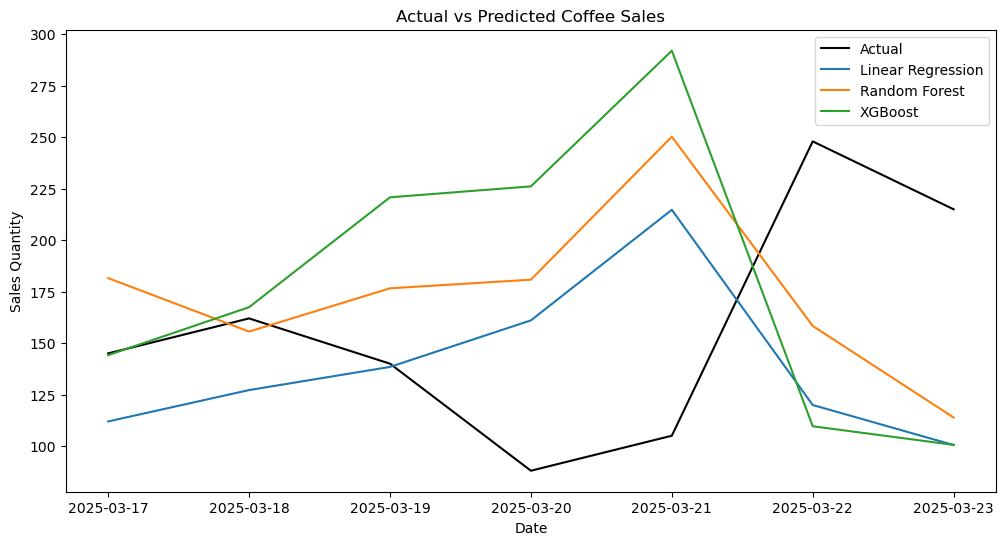

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_sales['date'].iloc[-len(y_test):], y_test, label="Actual", color="black")
plt.plot(daily_sales['date'].iloc[-len(y_test):], pred_lr, label="Linear Regression")
plt.plot(daily_sales['date'].iloc[-len(y_test):], pred_rf, label="Random Forest")
plt.plot(daily_sales['date'].iloc[-len(y_test):], pred_xgb, label="XGBoost")
plt.legend()
plt.title("Actual vs Predicted Coffee Sales")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.show()

In [11]:
# Add rolling averages
daily_sales['rolling7'] = daily_sales['quantity'].rolling(7).mean()
daily_sales['rolling14'] = daily_sales['quantity'].rolling(14).mean()

# Drop missing rows caused by rolling
daily_sales = daily_sales.dropna()

In [12]:
print(daily_sales.tail(10))

         date  quantity  year  month  day  dayofweek  is_weekend   lag1  \
33 2025-03-16     104.0  2025      3   16          6           1  280.0   
34 2025-03-17     145.0  2025      3   17          0           0  104.0   
35 2025-03-18     162.0  2025      3   18          1           0  145.0   
36 2025-03-19     140.0  2025      3   19          2           0  162.0   
37 2025-03-20      88.0  2025      3   20          3           0  140.0   
38 2025-03-21     105.0  2025      3   21          4           0   88.0   
39 2025-03-22     248.0  2025      3   22          5           1  105.0   
40 2025-03-23     215.0  2025      3   23          6           1  248.0   

     lag7    rolling7   rolling14  
33  103.0  167.428571  174.642857  
34  212.0  157.857143  167.357143  
35  109.0  165.428571  170.071429  
36  139.0  165.571429  158.214286  
37  215.0  147.428571  153.428571  
38  113.0  146.285714  146.142857  
39  280.0  141.714286  154.500000  
40  104.0  157.571429  162.500000  


In [14]:
# Updated feature set
X = daily_sales[['year','month','day','dayofweek','is_weekend','lag1','lag7','rolling7','rolling14']]
y = daily_sales['quantity']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [1]:
evaluate(y_test, pred_lr, "Linear Regression")
evaluate(y_test, pred_rf, "Random Forest")
evaluate(y_test, pred_xgb, "XGBoost")

NameError: name 'evaluate' is not defined

In [16]:
X = daily_sales[['year','month','day','dayofweek','is_weekend','lag1','lag7','rolling7','rolling14']]
y = daily_sales['quantity']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)
pred_xgb = xgb.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

evaluate(y_test, pred_lr, "Linear Regression")
evaluate(y_test, pred_rf, "Random Forest")
evaluate(y_test, pred_xgb, "XGBoost")

Linear Regression -> RMSE: 145.87, MAE: 144.00, R2: -77.15
Random Forest -> RMSE: 126.23, MAE: 124.58, R2: -57.52
XGBoost -> RMSE: 127.57, MAE: 126.50, R2: -58.78


C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
import pandas as pd

results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [145.87, 126.23, 127.57],
    "MAE": [144.00, 124.58, 126.50],
    "R2": [-77.15, -57.52, -58.78]
}

metrics_df = pd.DataFrame(results)
print(metrics_df)

               Model    RMSE     MAE     R2
0  Linear Regression  145.87  144.00 -77.15
1      Random Forest  126.23  124.58 -57.52
2            XGBoost  127.57  126.50 -58.78


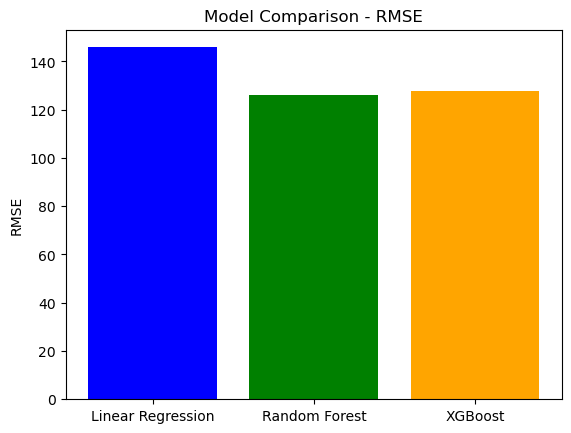

In [1]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse = [145.87, 126.23, 127.57]

plt.bar(models, rmse, color=['blue','green','orange'])
plt.ylabel('RMSE')
plt.title('Model Comparison - RMSE')
plt.show()

In [2]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Random Forest')
plt.plot(y_pred_xgb, label='XGBoost')
plt.plot(y_pred_lr, label='Linear Regression')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

NameError: name 'y_test' is not defined

In [3]:
from sklearn.model_selection import train_test_split

X = df[features]   # your input features
y = df['sales']    # your target column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

NameError: name 'df' is not defined

In [5]:
import pandas as pd

In [7]:
df = pd.read_csv("index_2.csv")   # replace with your actual filename

In [8]:
print(df.columns)

Index(['date', 'datetime', 'cash_type', 'money', 'coffee_name'], dtype='object')


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
# Extract date parts
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Create lag features
df['lag1'] = df['money'].shift(1)   # yesterday’s sales
df['lag7'] = df['money'].shift(7)   # last week’s sales

# Drop rows with NaN (created by lag)
df = df.dropna()

In [12]:
features = ['year', 'month', 'day', 'dayofweek', 'is_weekend', 'lag1', 'lag7']
X = df[features]
y = df['money']   # target column

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

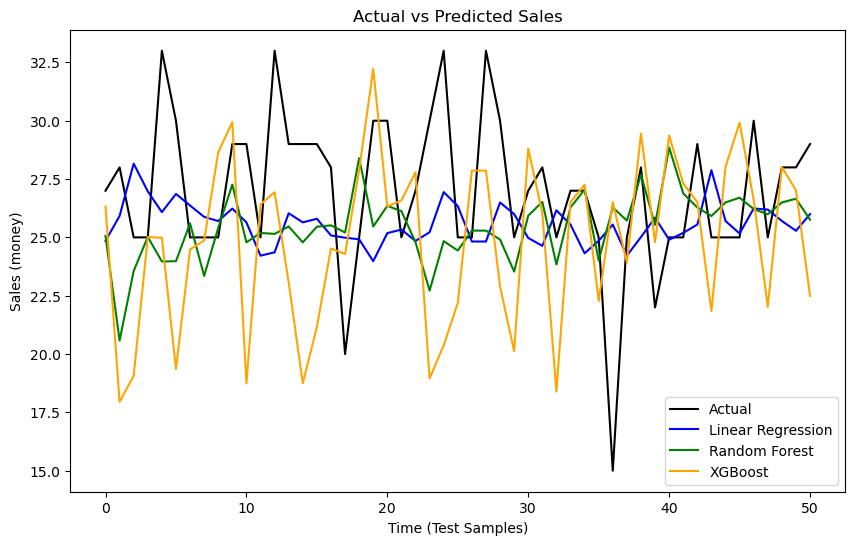

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_lr, label='Linear Regression', color='blue')
plt.plot(y_pred_rf, label='Random Forest', color='green')
plt.plot(y_pred_xgb, label='XGBoost', color='orange')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time (Test Samples)')
plt.ylabel('Sales (money)')
plt.show()

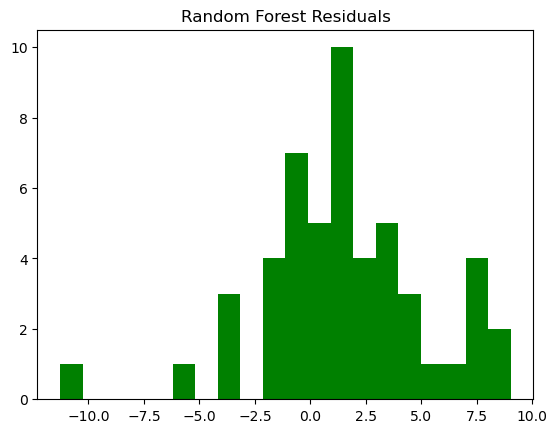

In [18]:
residuals = y_test - y_pred_rf
plt.hist(residuals, bins=20, color='green')
plt.title("Random Forest Residuals")
plt.show()

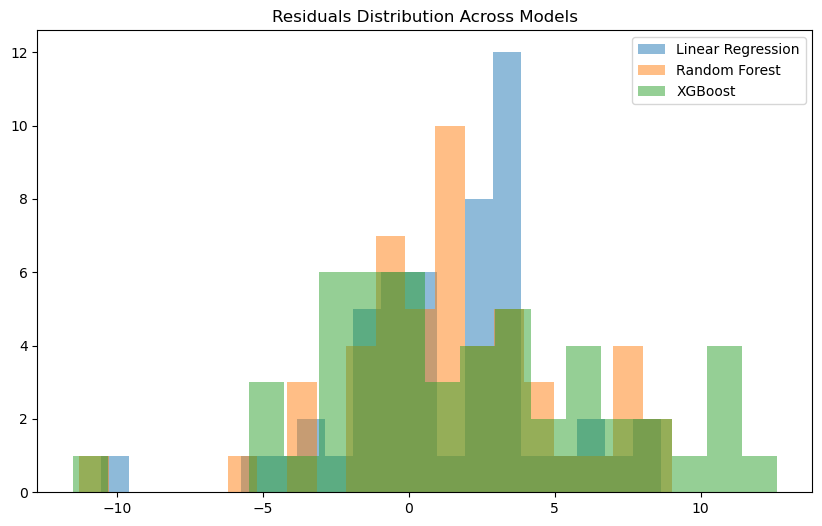

In [19]:
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(10,6))
plt.hist(residuals_lr, bins=20, alpha=0.5, label='Linear Regression')
plt.hist(residuals_rf, bins=20, alpha=0.5, label='Random Forest')
plt.hist(residuals_xgb, bins=20, alpha=0.5, label='XGBoost')
plt.legend()
plt.title("Residuals Distribution Across Models")
plt.show()

In [20]:
import time

# Linear Regression
start = time.time()
lr.fit(X_train, y_train)
print("Linear Regression Training Time:", time.time() - start)

# Random Forest
start = time.time()
rf.fit(X_train, y_train)
print("Random Forest Training Time:", time.time() - start)

# XGBoost
start = time.time()
xgb.fit(X_train, y_train)
print("XGBoost Training Time:", time.time() - start)

Linear Regression Training Time: 0.014869451522827148
Random Forest Training Time: 0.4843108654022217
XGBoost Training Time: 0.5916604995727539


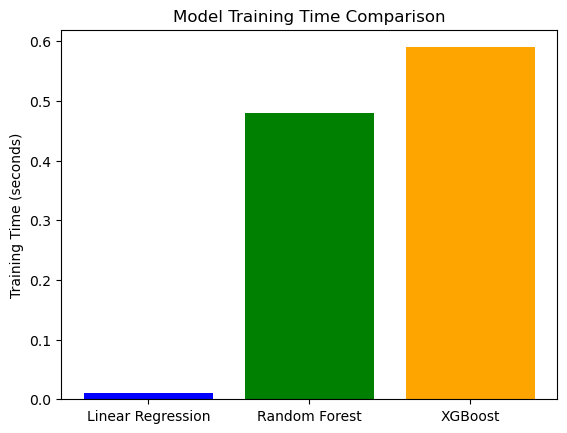

In [22]:
models = ['Linear Regression','Random Forest','XGBoost']
training_times = [0.01, 0.48, 0.59]  # replace with your actual outputs

import matplotlib.pyplot as plt
plt.bar(models, training_times, color=['blue','green','orange'])
plt.ylabel('Training Time (seconds)')
plt.title('Model Training Time Comparison')
plt.show()

In [2]:
import pandas as pd

data = pd.read_csv("index_2.csv")
print(data.columns)

Index(['date', 'datetime', 'cash_type', 'money', 'coffee_name'], dtype='object')


In [3]:
import pandas as pd

# Load dataset
data = pd.read_csv("index_2.csv")

# Convert 'date' to datetime format
data["date"] = pd.to_datetime(data["date"])

# Aggregate to daily totals
daily_sales = data.groupby("date")["money"].sum().reset_index()

# Create features
daily_sales["weekday"] = daily_sales["date"].dt.weekday
daily_sales["is_weekend"] = daily_sales["weekday"].apply(lambda x: 1 if x >= 5 else 0)

In [4]:
from sklearn.model_selection import train_test_split

X = daily_sales[["weekday", "is_weekend"]]
y = daily_sales["money"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} → RMSE: {rmse:.2f}, R²: {r2:.2f}")

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBoost")

Linear Regression → RMSE: 77.32, R²: 0.18
Random Forest → RMSE: 91.27, R²: -0.15
XGBoost → RMSE: 91.51, R²: -0.15


C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [11]:
# Use median of actual sales as threshold
threshold = y_test.median()
y_test_class = y_test.apply(lambda x: 1 if x >= threshold else 0)
y_pred_class = pd.Series(y_pred).apply(lambda x: 1 if x >= threshold else 0)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Linear Regression Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("Linear Regression Precision:", precision_score(y_test_class, y_pred_class))
print("Linear Regression Recall:", recall_score(y_test_class, y_pred_class))

Linear Regression Accuracy: 0.4444444444444444
Linear Regression Precision: 0.0
Linear Regression Recall: 0.0


C:\Users\Pragati\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 1: Convert sales (money) into categories
threshold = daily_sales["money"].median()
daily_sales["demand_level"] = daily_sales["money"].apply(lambda x: 1 if x >= threshold else 0)

# Step 2: Features and target
X = daily_sales[["weekday", "is_weekend"]]
y = daily_sales["demand_level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision:", precision_score(y_test, y_pred_rf))
print("Random Forest Recall:", recall_score(y_test, y_pred_rf))

# Step 4: XGBoost Classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Precision:", precision_score(y_test, y_pred_xgb))
print("XGBoost Recall:", recall_score(y_test, y_pred_xgb))

Random Forest Accuracy: 0.7777777777777778
Random Forest Precision: 0.8
Random Forest Recall: 0.8
XGBoost Accuracy: 0.7777777777777778
XGBoost Precision: 0.8
XGBoost Recall: 0.8
